## Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt, transforms
import random
import pandas as pd
# from Load_Recording_Data import LoadRecordingData, Recording  # (Use this for old data)
from load_recording_data import LoadRecordingData#, Recording   # (Use this for new data)
import scipy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
import pysindy as ps
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.integrate import quad
import tensorflow as tf
import keras
from fastdtw import fastdtw
import itertools

2024-02-03 15:17:18.660861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-03 15:17:19.516207: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-03 15:17:19.516315: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-02-03 15:17:19.516326: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpu_id = 3
tf.config.set_visible_devices(gpus[gpu_id], 'GPU')

## Load data

In [45]:
intrasTrainVal, extrasTrainVal, intrasTest, extrasTest = LoadRecordingData()
idx_train, idx_val = train_test_split(np.arange(len(intrasTrainVal)), test_size=0.20) #, random_state=42)

extrasTrain = extrasTrainVal[idx_train]
intrasTrain = intrasTrainVal[idx_train]
extrasVal = extrasTrainVal[idx_val]
intrasVal = intrasTrainVal[idx_val]


# dataset = LoadRecordingData()
# # idx_train, idx_test = train_test_split(np.arange(len(intrasRaw)), test_size=0.25, random_state=42)

# extrasTrain = dataset['8k'].extras_training2
# intrasTrain = dataset['8k'].intras_training2
# extrasVal = dataset['8k'].extras_val2
# intrasVal = dataset['8k'].intras_val2
# extrasTest = dataset['8k'].extras_unseen2
# intrasTest = dataset['8k'].intras_unseen2

W5FebD1_10nM_Dofe_51_52_8000
W5FebD1_10nM_Dofe_57_58_8000
W5FebD1_10nM_Dofe_84_85_8000
W8FebD2_10nM_Dofe_57_47_8000
W8FebD2_10nM_Dofe_84_74_8000
W8FebD3_10nM_Dofe_24_14_8000
W8FebD3_10nM_Dofe_61_62_8000


## Helper functions

In [46]:
# Takes in a 1-dimensional array and a window size, and applies a moving
# average filter to data.
def moving_filter(data, window_size):
    i = 0
    moving_averages = []
    while i < len(data) - window_size + 1:
        this_window = data[i : i + window_size]

        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += 1

    for i in range(window_size - 1):
        ind = len(data) - (window_size - i)
        moving_averages.append(np.mean(data[ind-window_size:ind]))

    return moving_averages

def mse(y, p):
    return np.mean((y-p)**2)

def mae(y, p):
    return np.mean(np.absolute(y-p))

def dtw(y, p):
    distances = []
    
    for i in range(len(y)):
        dist, _ = fastdtw(y[i], p[i])
        distances.append(dist)
        
    return np.mean(np.array(distances))

def sigmoid(x):
    return 1/(1 + np.exp(-x))

### Smooth the data by applying moving filter

In [47]:
# Apply moving filter on intras and extras
# Training set
windowSize = 20
temp = []

for rec in intrasTrain:
    temp.append(moving_filter(rec, windowSize))
    
intrasTrain = np.array(temp)
temp = []

for rec in extrasTrain:
    temp.append(moving_filter(rec, windowSize))
    
extrasTrain = np.array(temp)

# Validation set
temp = []

for rec in intrasVal:
    temp.append(moving_filter(rec, windowSize))
    
intrasVal = np.array(temp)
temp = []

for rec in extrasVal:
    temp.append(moving_filter(rec, windowSize))
    
extrasVal = np.array(temp)


# Test set
temp = []

for rec in intrasTest:
    temp.append(moving_filter(rec, windowSize))
    
intrasTest = np.array(temp)
temp = []

for rec in extrasTest:
    temp.append(moving_filter(rec, windowSize))
    
extrasTest = np.array(temp)

### Function to extract features

In [48]:
def GetFeatures(intras, extras):
    X = []
    Y = []
    windowSize = 20
    
    featureNames = ['d2eAP', 'deAP', 'eAP', 'exp(d2eAP)', 'exp(deAP)', 'exp(eAP)', 't']#, 'distFromMax', 'distFromMin']
    s = [i for i in range(len(featureNames))]
    combs = [list(itertools.combinations(s, r)) for r in range(len(s)+1)]
    featureCombs = []
    
    for comb in combs[1:]:
        for tpl in comb:
            name = ""

            for ind in tpl:
                name += "*"+featureNames[ind]

            featureCombs.append(name)
            
    t = np.array([i for i in range(len(extras[0]))])/len(extras[0])
            
    for i in range(len(extras)):
        iAP = intras[i]
        diAP = np.array(moving_filter(np.gradient(iAP), windowSize))
        d2iAP = np.array(moving_filter(np.gradient(diAP), windowSize))

        eAP = extras[i]
        deAP = np.array(moving_filter(np.gradient(eAP), windowSize))
        d2eAP = np.array(moving_filter(np.gradient(deAP), windowSize))
            
#         iAP = intras[i]
#         diAP = np.gradient(iAP)
#         d2iAP = np.gradient(diAP)

#         eAP = extras[i]
#         deAP = np.gradient(eAP)
#         d2eAP = np.gradient(deAP)


        featureList = [d2eAP, deAP, eAP, np.exp(d2eAP), np.exp(deAP), np.exp(eAP), t]
    

#         maxInd = np.argmax(eAP[:1500])
#         minInd = 1500 + np.argmin(eAP[1500:])

#         distFromMax = [i for i in range(len(extras[0]))]
#         distFromMin = [i for i in range(len(extras[0]))]

#         distFromMax = np.exp(-np.absolute(distFromMax - maxInd))
#         distFromMin = np.exp(-np.absolute((distFromMin - minInd)/50))

#         featureList.append(distFromMax)
#         featureList.append(distFromMin)
            
        featureMatrix = []
        
        for comb in combs[1:]:
            for tpl in comb:
                feature = 1
                
                for ind in tpl:
                    feature = feature*featureList[ind]
                    
                featureMatrix.append(feature)
        
        
######### Uncomment the following to add a parameter for some finite timesteps
######### around positive peak in eAP and local minima in latter half of eAP
#         oneHotMatrix = []
#         maxInd = np.argmax(eAP[:1500])
#         minInd = 1500 + np.argmin(eAP[1500:])


#         for j in range(maxInd-50, maxInd+50):
#             temp = list(np.zeros(len(eAP)))
#             temp[j] = 1
#             oneHotMatrix.append(temp)

#         for j in range(100):
#             temp = list(np.zeros(len(eAP)))

#             for i in range(minInd-500+10*j, minInd-500+10*j+10):
#                 temp[i] = 1

#             oneHotMatrix.append(temp)

#         featureMatrix.extend(oneHotMatrix)
        
        X.extend(np.array(featureMatrix).T)
        Y.extend(iAP)
        
    X = np.array(X)
    Y = np.array(Y)
     
    return X, Y

### Extract features from training data

In [49]:
X0, Y0 = GetFeatures(intrasTrain, extrasTrain)
scaler0 = StandardScaler()
# scalerY0 = StandardScaler()

X0 = scaler0.fit_transform(X0)
# Y0 = scalerY0.fit_transform(Y0.reshape(-1, 1)).reshape(-1)

### Extract features from validation and test data for hyperparam tuning and evaluation

In [50]:
X_val0, Y_val0 = GetFeatures(intrasVal, extrasVal)
X_val0 = scaler0.transform(X_val0)
# Y_val0 = scalerY0.transform(Y_val0.reshape(-1, 1)).reshape(-1)

In [51]:
X_test0, Y_test0 = GetFeatures(intrasTest, extrasTest)
X_test0 = scaler0.transform(X_test0)

### Estimate parameters of Physics loss equation

In [125]:
# This cell estimates parameters in physics loss equation using training data.
# This equation is then used as a constraint in the loss function of the model.
windowSize = 20

v = intrasTrain
dv = []
d2v = []
d3v = []

for rec in v:
    dv.append(moving_filter(np.gradient(rec), windowSize))

dv = np.array(dv)

for rec in dv:
    d2v.append(moving_filter(np.gradient(rec), windowSize))

d2v = np.array(d2v)

for rec in d2v:
    d3v.append(moving_filter(np.gradient(rec), windowSize))

d3v = np.array(d3v)

v = np.reshape(v, (-1))
dv = np.reshape(dv, (-1))
d2v = np.reshape(d2v, (-1))
d3v = np.reshape(d3v, (-1))

vFeatures = np.array([d2v*(v**2), v**3, dv*(v**2), v**4, v*d2v, v*dv, (d2v)**2, (d2v*dv), (v**3)*d2v, (v**3)*dv, v**5, (dv)**2, 
                      d2v, d3v*v, dv, np.ones(v.shape)]).T

target = np.array([d3v*(v**2)]).T
params = np.linalg.inv(vFeatures.T.dot(vFeatures)).dot(vFeatures.T.dot(target))

### Linear regression model with custom loss

In [126]:
class LinearReg(keras.layers.Layer):
    def __init__(self, numParams, lamda):
        super(LinearReg, self).__init__()
        self.w = self.add_weight(shape=(numParams, 1), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(1,), initializer="zeros", trainable=True)
        self.lamda = lamda
        
    def call(self, x):
        return tf.matmul(x, self.w) + self.b
    
    def loss_fn(self, output, target):
        reg = self.lamda*(tf.math.reduce_sum(tf.math.abs(self.w)) + tf.math.reduce_sum(tf.math.abs(self.b)))
        sqError = tf.math.reduce_sum(tf.math.square(output - target))
        
        dv = tf.reshape(output, (-1)).numpy()
        v = np.cumsum(dv)
        d2v = np.gradient(dv)
        d3v = np.gradient(d2v)
        
        vFeatures = np.array([d2v*(v**2), v**3, dv*(v**2), v**4, v*d2v, v*dv, (d2v)**2, (d2v*dv), (v**3)*d2v, (v**3)*dv, v**5, (dv)**2, 
                      d2v, d3v*v, dv, np.ones(v.shape)]).T
        target = np.array([d3v*(v**2)]).T
        
        phyErr = tf.reduce_mean(tf.math.square(vFeatures.dot(params) - target))
#         d1mse = tf.reduce_mean(tf.math.square(tf.math.cumsum(output, 0) - tf.math.cumsum(target, 0)))
#         mse = tf.reduce_mean(tf.math.square(tf.math.cumsum(tf.math.cumsum(output, 0), 0) - tf.math.cumsum(tf.math.cumsum(target, 0), 0)))

        return reg + sqError + tf.cast(phyErr, tf.float32)# + d1mse + mse

### Training

In [161]:
X = X0[:, mask]
Y = Y0
X_val = X_val0[:, mask]
Y_val = Y_val0
X_test = X_test0[:, mask]
Y_test = Y_test0

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-5, decay_steps=10000, decay_rate=0.95)

epochs = 100
batch_size = len(extrasTrain[0])

reg_selected = LinearReg(X.shape[1], 0.001)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
X_tensor = tf.convert_to_tensor(X, dtype='float32')
Y_tensor = tf.convert_to_tensor(Y, dtype='float32')

for epoch in range(epochs):
    totalLoss = 0.0

    for i in range(0, len(X_tensor), batch_size):
        loss= 0.0
        
        with tf.GradientTape() as tape:
            output = reg_selected(X_tensor[i:i+batch_size])
            output = tf.reshape(output, (-1))
            loss = reg_selected.loss_fn(output, Y_tensor[i:i+batch_size])
            totalLoss += loss
    
        grads = tape.gradient(loss, reg_selected.trainable_weights)
        optimizer.apply_gradients(zip(grads, reg_selected.trainable_weights))
        
    if(epoch%10==0):
        print("Epoch ", epoch, " complete with loss ", totalLoss/len(X_tensor)*batch_size)

output = reg_selected(X_tensor)
output = tf.reshape(output, (-1)).numpy()
    
print("MSE on train with model", mse(output, Y))
print("MAE on train with model", mae(output, Y))

valOut = reg_selected(tf.convert_to_tensor(X_val, dtype='float32'))
valOut = tf.reshape(valOut, (-1)).numpy()

print("MSE on val with model", mse(valOut, Y_val))
print("MAE on val with model", mae(valOut, Y_val))

# print(reg_selected.w.numpy())
# print(reg_selected.b.numpy())

Epoch  0  complete with loss  tf.Tensor(11908260.0, shape=(), dtype=float32)
Epoch  10  complete with loss  tf.Tensor(0.0066808844, shape=(), dtype=float32)
Epoch  20  complete with loss  tf.Tensor(0.0066736136, shape=(), dtype=float32)
Epoch  30  complete with loss  tf.Tensor(0.0066597466, shape=(), dtype=float32)
Epoch  40  complete with loss  tf.Tensor(0.006646757, shape=(), dtype=float32)
Epoch  50  complete with loss  tf.Tensor(0.0066345143, shape=(), dtype=float32)
Epoch  60  complete with loss  tf.Tensor(0.0066228956, shape=(), dtype=float32)
Epoch  70  complete with loss  tf.Tensor(0.006611758, shape=(), dtype=float32)
Epoch  80  complete with loss  tf.Tensor(0.0066009886, shape=(), dtype=float32)
Epoch  90  complete with loss  tf.Tensor(0.00659059, shape=(), dtype=float32)
MSE on train with model 8.380114439509237e-07
MAE on train with model 0.00026077173173626384
MSE on val with model 8.348966504446406e-07
MAE on val with model 0.00026326060571060545


### Select features with high coefficient magnitude

In [159]:
featureWeights = np.absolute(np.reshape(reg_selected.w.numpy(), (-1)))
mask = featureWeights >= np.sort(featureWeights)[-4]

In [160]:
featureNames = ['d2eAP', 'deAP', 'eAP', 'np.exp(d2eAP)', 'np.exp(deAP)', 'np.exp(eAP)']#, 'distFromMax', 'distFromMin']
s = [i for i in range(len(featureNames))]
combs = [list(itertools.combinations(s, r)) for r in range(len(s)+1)]
featureCombs = []

for comb in combs[1:]:
    for tpl in comb:
        name = ""

        for ind in tpl:
            name += "*"+featureNames[ind]

        featureCombs.append(name)

#### Only for weight params
# featureCombs.extend(["max"+str(i) for i in range(-50, 50)])
# featureCombs.extend(["min"+str(i) for i in range(100)])
####

np.array(featureCombs)[mask]

array(['*d2eAP', '*np.exp(d2eAP)', '*np.exp(eAP)',
       '*deAP*eAP*np.exp(d2eAP)*np.exp(deAP)'], dtype='<U54')

In [162]:
print(reg_selected.w.numpy())
print(reg_selected.b.numpy())

[[ 0.00060496]
 [-0.0007304 ]
 [ 0.00027668]
 [-0.00060775]]
[1.052068e-05]


### Linear Regression model using Scikit and Lasso selection

In [52]:
lamda = 0.01
selector = SelectFromModel(Lasso(alpha=lamda, random_state=10))
X = X0
Y = Y0
X_val = X_val0
Y_val = Y_val0
X_test = X_test0
Y_test = Y_test0
selector.fit(X, Y)

print(selector.get_support())

X_selected = selector.transform(X)
reg_selected = Lasso(alpha=lamda, random_state=10).fit(X_selected, Y)

print(reg_selected.coef_)
print(reg_selected.intercept_)

predTrain = reg_selected.predict(X_selected)
print("MSE on train with reg_selected", mse(predTrain, Y))
print("MAE on train with reg_selected", mae(predTrain, Y))

[False False False False False False  True False False False False False
 False False False False False False  True  True False False  True False
  True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False  True False False False False  True  True
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]
[-0.18336134 -0.04710312 -0.03946474 -0.01991385 -0.0448535  -0.00693722
 -0.01033371 -0.00253224 -0.02629733  0.07138068 -0.04317678 -0.01934933
  0.03030256]
0.4163174368488418
MSE on train with reg_selected 0.05796378814542

### Evaluate model on val data

In [43]:
# predd2_selected = tf.reshape(reg_selected(tf.convert_to_tensor(X_val, dtype='float32')), (-1, 8000)).numpy()
# predd2_selected = tf.reshape(valOut, (-1, 8000)).numpy()
# predd2_selected = np.array(reg_selected.predict(selector.transform(X_val))).reshape((-1, 8000))

# predd1_selected = np.array(reg_selected.predict(selector.transform(X_val))).reshape((-1, 8000))
# predd1_selected = np.cumsum(predd2_selected, axis=1)

prediAP_selected = np.array(reg_selected.predict(selector.transform(X_val))).reshape((-1, 8000))
# prediAP_selected = np.cumsum(predd1_selected, axis=1)

yiAP = intrasVal

print("MSE on test d0 with reg_selected", mse(prediAP_selected, yiAP))
print("MAE on test d0 with reg_selected", mae(prediAP_selected, yiAP))
print("DTW on test d0 with reg_selected", dtw(prediAP_selected, yiAP))

MSE on test d0 with reg_selected 0.05805156460104431
MAE on test d0 with reg_selected 0.18875734811734934
DTW on test d0 with reg_selected 910.9863700323876


### Evaluate model on test data

In [53]:
# predd2_selected = tf.reshape(reg_selected(tf.convert_to_tensor(X_test, dtype='float32')), (-1, 8000)).numpy()
# predd2_selected = tf.reshape(valOut, (-1, 8000)).numpy()
# predd2_selected = np.array(reg_selected.predict(selector.transform(X_test))).reshape((-1, 8000))

# predd1_selected = np.array(reg_selected.predict(selector.transform(X_test))).reshape((-1, 8000))
# predd1_selected = np.cumsum(predd2_selected, axis=1)

prediAP_selected = np.array(reg_selected.predict(selector.transform(X_test))).reshape((-1, 8000))
# prediAP_selected = np.cumsum(predd1_selected, axis=1)

# yd2 = np.array(Y_test).reshape((-1, 8000))
# yd1 = np.cumsum(yd2, axis=1)
yiAP = intrasTest #np.cumsum(yd1, axis=1)

# print("MSE on test d2 with reg_selected", mse(predd2_selected, yd2))
# print("MSE on test d1 with reg_selected", mse(predd1_selected, yd1))
print("MSE on test d0 with reg_selected", mse(prediAP_selected, yiAP))
# print("MAE on test d2 with reg_selected", mae(predd2_selected, yd2))
# print("MAE on test d1 with reg_selected", mae(predd1_selected, yd1))
print("MAE on test d0 with reg_selected", mae(prediAP_selected, yiAP))
# print("DTW on test d2 with reg_selected", dtw(predd2_selected, yd2))
# print("DTW on test d1 with reg_selected", dtw(predd1_selected, yd1))
print("DTW on test d0 with reg_selected", dtw(prediAP_selected, yiAP))

MSE on test d0 with reg_selected 0.05257039212420605
MAE on test d0 with reg_selected 0.1790429606355866
DTW on test d0 with reg_selected 604.914028230179


### Important feature selection using Lasso

In [18]:
featureNames = ['d2eAP', 'deAP', 'eAP', 'np.exp(d2eAP)', 'np.exp(deAP)', 'np.exp(eAP)', 't']#, 'distFromMax', 'distFromMin']
s = [i for i in range(len(featureNames))]
combs = [list(itertools.combinations(s, r)) for r in range(len(s)+1)]
featureCombs = []

for comb in combs[1:]:
    for tpl in comb:
        name = ""

        for ind in tpl:
            name += "*"+featureNames[ind]

        featureCombs.append(name)

#### Only for weight params
# featureCombs.extend(["max"+str(i) for i in range(-50, 50)])
# featureCombs.extend(["min"+str(i) for i in range(100)])
####

np.array(featureCombs)[selector.get_support()]

array(['*d2eAP*deAP', '*deAP*eAP*np.exp(deAP)*t'], dtype='<U56')

In [108]:
# 54, 12, 40
import pickle
diAP_physics = {}

### Choose a recording at random from the test set

In [43]:
ind = 79#random.randint(0, len(extrasTest))#54, 12, 40, 308, 202
print(ind)

x, y = selector.transform(X_test)[ind*len(extrasTest[0]): (ind+1)*len(extrasTest[0])], Y_test[ind*len(extrasTest[0]): (ind+1)*len(extrasTest[0])]
# x, y = X_test[ind*len(extrasTest[0]): (ind+1)*len(extrasTest[0])], Y_test[ind*len(extrasTest[0]): (ind+1)*len(extrasTest[0])]

79


### Get model prediction for the chosen recording

In [44]:
# pred = tf.reshape(reg_selected(tf.convert_to_tensor(x, dtype='float32')), (-1)).numpy()
pred = reg_selected.predict(x)

### Prediction plots

(-0.1284779565767377, 1.1)

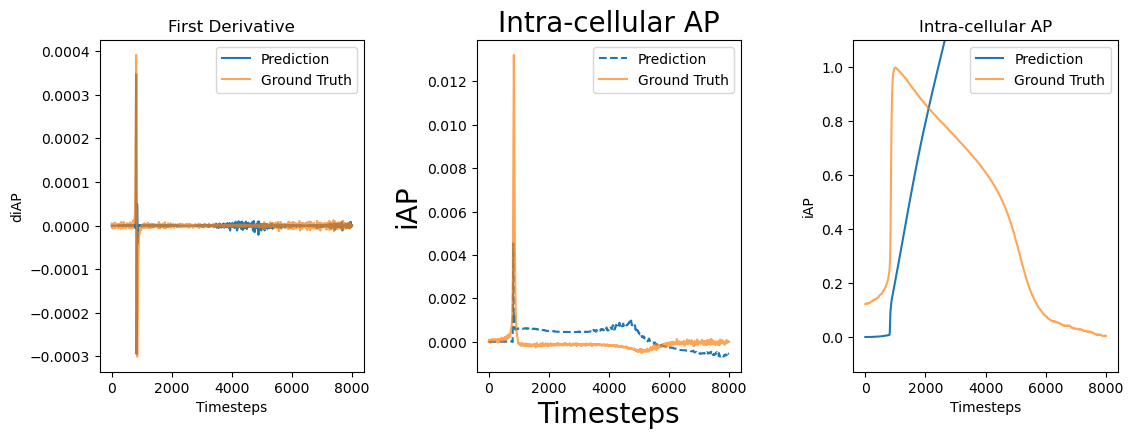

In [45]:
transparency = 0.7
fig0, ax0 = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
fig0.tight_layout(pad=5)

# Plot second derivative
ax0[0].plot(pred)
ax0[0].plot(y, alpha=transparency)
ax0[0].legend(['Prediction', 'Ground Truth'])
ax0[0].title.set_text("First Derivative")
ax0[0].set_xlabel("Timesteps")
ax0[0].set_ylabel("diAP")

# Plot first derivative
ax0[1].plot(np.cumsum(pred), linestyle='dashed')
ax0[1].plot(moving_filter(np.gradient(intrasTest[ind]), windowSize), alpha=transparency)
# ax0[1].plot(intrasTest[ind], alpha=transparency, color='red')
ax0[1].legend(['Prediction', 'Ground Truth'])#, prop={'size': 18})
ax0[1].title.set_text("Intra-cellular AP")
ax0[1].title.set_fontsize(20)
ax0[1].set_xlabel("Timesteps", fontsize=20)
ax0[1].set_ylabel("iAP", fontsize=20)
# ax0[1].set_ylim([-0.2, 1.1])
# ax0[1].tick_params(axis='x', labelsize=16)
# ax0[1].tick_params(axis='y', labelsize=16)

# Plot iAP
ax0[2].plot(np.cumsum(np.cumsum(pred)))
ax0[2].plot(intrasTest[ind], alpha=transparency)
ax0[2].legend(['Prediction', 'Ground Truth'])
ax0[2].title.set_text("Intra-cellular AP")
ax0[2].set_xlabel("Timesteps")
ax0[2].set_ylabel("iAP")
ax0[2].set_ylim([None, 1.1])

In [231]:
diAP_physics[40] = [np.cumsum(pred), intrasTest[ind]]

In [232]:
diAP_physics

{54: [array([0.00028079, 0.00055631, 0.00083751, ..., 0.09181637, 0.09192687,
         0.09203786], dtype=float32),
  array([0.11597529, 0.11597529, 0.11595322, ..., 0.00229479, 0.00225066,
         0.00218447])],
 12: [array([0.00018628, 0.00036784, 0.00057274, ..., 0.09694407, 0.09701141,
         0.09708039], dtype=float32),
  array([0.11780515, 0.11789847, 0.11812243, ..., 0.00369541, 0.00371407,
         0.00373274])],
 40: [array([0.00031644, 0.0006379 , 0.00096405, ..., 0.06581122, 0.06583679,
         0.06586347], dtype=float32),
  array([0.11644407, 0.11652755, 0.11661102, ..., 0.0029424 , 0.00296327,
         0.00290067])]}

In [233]:
with open('diAP_physics.pkl', 'wb') as fl:
    pickle.dump(diAP_physics, fl)